# Optimización de Perceptrón multicapa (MLP) para el Análisis de Pymes (SME)
### De los Árboles a las Redes Neuronales: Un enfoque robusto de Hiperparametrización

¡Hola de nuevo! En esta sesión, daremos un salto cualitativo. Tomaremos como base nuestro análisis de Pymes y, en lugar de usar un Árbol de Decisión, entrenaremos una **Red Neuronal Artificial (MLP)**.

A diferencia de los árboles, las redes neuronales son muy sensibles a la escala de los datos y a su configuración. Por ello, hoy aprenderemos a:
1.  **Automatizar la selección de variables** con `SelectKBest`.
2.  **Construir un Pipeline profesional** que incluya escalado, selección y clasificación.
3.  **Realizar una búsqueda estocástica de hiperparámetros** (`RandomizedSearchCV`) para encontrar la mejor arquitectura y aprender a optimizar el `ROC AUC`.

---

## 1. Configuración del Entorno
Importamos las librerías necesarias, incluyendo herramientas de visualización avanzada y optimización.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
)
import graphviz

# Configuración estética premium
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
ALLIANZ_BLUE = '#003882'
VIBRANT_PURPLE = '#7153ff'

## 2. Carga y Preparación de Datos
Mantenemos la lógica de filtrado inicial para que nuestros resultados sean comparables con el modelo proyector anterior.

In [3]:
# Cargar el dataset
df = pd.read_csv('../data/sme_mx.csv')

# Filtrar altaSAT <> 'o' y mapear a binario
df_filtered = df[df['altaSAT'] != 'o'].copy()
df_filtered['target'] = df_filtered['altaSAT'].map({'s': 1, 'n': 0})

# Selección de columnas (incluimos más para dejar que el modelo decida)
cols_to_keep = [
    'edadEmprendedor', 'sexoEmprendedor', 'escolaridadEmprendedor', 
    'dependientesEconomicos', 'estadoCivil', 'familiaAyuda', 
    'antiguedadNegocio', 'giroNegocio', 'numEmpleados', 
    'ventasPromedioDiarias', 'registroVentas', 'registroContabilidad', 
    'usaCredito', 'tiempoCreditoProveedores', 'target'
]

df_model = df_filtered[cols_to_keep].dropna().copy()

X = df_model.drop(columns=['target'])
y = df_model['target']

# One-Hot Encoding para todas las variables categóricas
cat_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print(f"Total de variables tras encoding: {X_encoded.shape[1]}")

Total de variables tras encoding: 106


/var/folders/b2/142kycp96wdg69k6pkw9_vf00000gp/T/ipykernel_20227/4058091402.py:23: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include=['object']).columns


## 3. Construcción del Pipeline Industrial
Para redes neuronales, el orden de los factores **sí altera el producto**:
1.  **StandardScaler**: Normaliza los datos (media 0, varianza 1). Crucial para que el gradiente converja.
2.  **SelectKBest**: Selecciona las $k$ mejores variables según la prueba ANOVA F-value.
3.  **MLPClassifier**: Nuestro cerebro artificial.

In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif)),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])

# Partición de datos
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42, stratify=y)

## 4. Etapa Robusta de Hiperparametrización
Usaremos `RandomizedSearchCV`. Esto es didáctico porque simula una situación real donde no tenemos tiempo de probar todo, pero queremos una muestra representativa del espacio de soluciones.

**Ojo**: Observen cómo incluimos `selector__k` como parámetro a optimizar.

In [5]:
param_distributions = {
    'selector__k': [5, 10, 20, 40, 'all'],
    'mlp__hidden_layer_sizes': [(10,), (20,), (10, 10), (5, 5)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01]
}

print("Iniciando búsqueda aleatoria de hiperparámetros (RandomizedSearchCV)... ")
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions, 
    n_iter=20, 
    cv=3, 
    scoring='roc_auc', 
    random_state=42, 
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("\n--- Mejores Resultados ---")
print(f"Mejor parámetros: {random_search.best_params_}")
print(f"Mejor ROC AUC Score: {random_search.best_score_:.4f}")

Iniciando búsqueda aleatoria de hiperparámetros (RandomizedSearchCV)... 
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [22 24 25 27 36 37 38 48 50 51 53 55 60 61 62 64 67 74 75 79 81 85 86 87
 88 90 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [19 24 25 26 27 28 29 30 31 37 38 41 46 48 56 57 58 59 64 66 67 68 69 75
 77 79 83 85 86 87 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univa


--- Mejores Resultados ---
Mejor parámetros: {'selector__k': 40, 'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (20,), 'mlp__alpha': 0.01, 'mlp__activation': 'tanh'}
Mejor ROC AUC Score: 0.7506


/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


## 5. Evaluación Detallada
Ahora evaluamos el mejor modelo encontrado en nuestro "examen final" (el set de prueba).

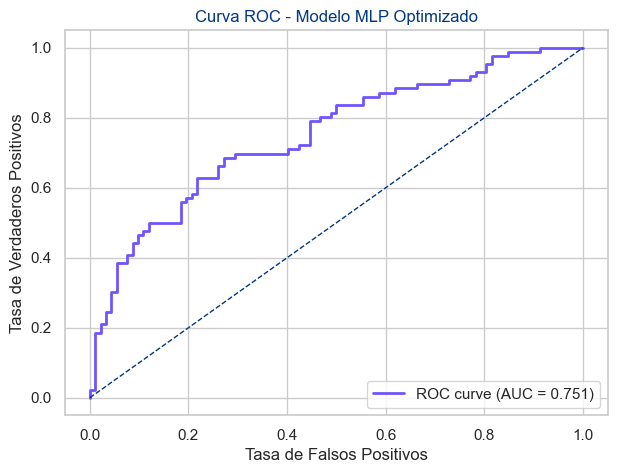


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70        92
           1       0.68      0.70      0.69        86

    accuracy                           0.70       178
   macro avg       0.70      0.70      0.70       178
weighted avg       0.70      0.70      0.70       178



In [6]:
best_model = random_search.best_estimator_
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color=VIBRANT_PURPLE, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color=ALLIANZ_BLUE, lw=1, linestyle='--')
plt.title('Curva ROC - Modelo MLP Optimizado', color=ALLIANZ_BLUE)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc="lower right")
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

## 6. Visualización Bella de la Arquitectura
Una red neuronal no es una caja negra. Vamos a visualizar la estructura que el optimizador eligió.

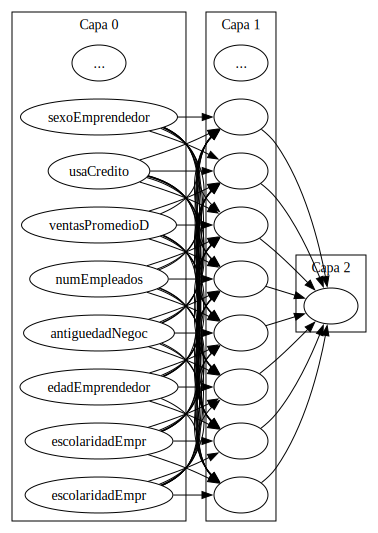

In [7]:
def visualize_network(mlp, input_features):
    dot = graphviz.Digraph(comment='MLP Architecture', graph_attr={'rankdir': 'LR'})
    
    # Capas: Entrada, Ocultas, Salida
    layer_sizes = [len(input_features)] + list(mlp.hidden_layer_sizes) + [1]
    
    for i, size in enumerate(layer_sizes):
        with dot.subgraph(name=f'cluster_{i}') as c:
            c.attr(label=f'Capa {i}')
            # Para no saturar el dibujo, mostramos máximo 10 nodos por capa
            nodes_to_show = min(size, 8)
            for j in range(nodes_to_show):
                node_id = f'{i}_{j}'
                label = ""
                if i == 0 and j < len(input_features):
                    label = input_features[j][:15] # Nombre de la variable
                c.node(node_id, label)
            if size > nodes_to_show:
                c.node(f'{i}_more', '...')

    # Conexiones (Solo demostrativas entre capas)
    for i in range(len(layer_sizes) - 1):
        n1 = min(layer_sizes[i], 8)
        n2 = min(layer_sizes[i+1], 8)
        for j in range(n1):
            for k in range(n2):
                dot.edge(f'{i}_{j}', f'{i+1}_{k}', alpha='0.1')

    return dot

# Obtener los nombres de las variables que pasaron el filtro de SelectKBest
mask = best_model.named_steps['selector'].get_support()
selected_features = X_train.columns[mask].tolist()

dot_graph = visualize_network(best_model.named_steps['mlp'], selected_features)
dot_graph

---
### Lecciones para los alumnos de posgrado:
1.  **El escalamiento no es opcional**: Sin `StandardScaler`, la red podría no aprender nada.
2.  **Selección dentro del Pipeline**: Al incluir el `selector` en la búsqueda, evitamos el sesgo de selección y encontramos el número ideal de variables para esta arquitectura.
3.  **ROC AUC**: Nos dice qué tan bien separa la red a los emprendedores "buenos" de los "malos" sin importar el umbral de decisión.


**Sugerencia del Dr. Fuentes**: ¡Experimenten cambiando el `n_iter` en el `RandomizedSearchCV` para ver si encuentran modelos aún mejores!